In [295]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [296]:
class WikiArtDataset(Dataset):
    def __init__(self, h5_path: str, transform=None, mask_transform=None, mask_type='square'):
        self.h5_path = h5_path
        self.transform = transform
        self.mask_transform = mask_transform
        self.mask_type = mask_type

        with h5py.File(self.h5_path, 'r') as h5f:
            self.length = len(h5f['images'])

    def __len__(self):
        return self.length

    def _open_hdf5(self):
        if not hasattr(self, '_hf') or self._hf is None:
            self._hf = h5py.File(self.h5_path, 'r')

    def _generate_square_mask(self, image, min_square_side=14, max_square_side=24):
        width, height = image.shape[1], image.shape[2]

        mask = np.zeros((height, width), dtype=np.uint8)

        square_side = np.random.randint(min_square_side, max_square_side + 1)
        
        x = np.random.randint(0, width - square_side)
        y = np.random.randint(0, height - square_side)

        mask[y:y + square_side, x:x + square_side] = 1
        
        return mask

    def _generate_irregular_mask(self, image, max_radius=12, min_radius=6, points=10):
        width, height = image.shape[1], image.shape[2]

        mask = np.zeros((height, width), dtype=np.uint8)

        x_center = np.random.randint(max_radius, width - max_radius)
        y_center = np.random.randint(max_radius, height - max_radius)

        angles = np.linspace(0, 2 * np.pi, points, endpoint=False)
        radii = np.random.randint(min_radius, max_radius, size=points)
        vertices = [
            (
                int(x_center + radius * np.cos(angle)),
                int(y_center + radius * np.sin(angle))
            )
            for angle, radius in zip(angles, radii)
        ]

        vertices.append(vertices[0])

        polygon = np.array(vertices, dtype=np.int32)
        cv2.fillPoly(mask, [polygon], 1)

        return mask

    def __getitem__(self, idx):
        self._open_hdf5()

        image = self._hf['images'][idx]
        image = torch.from_numpy(image).float()

        if self.transform:
            image = self.transform(image)

        if self.mask_type == 'square':
            mask = self._generate_square_mask(image)
        elif self.mask_type == 'irregular':
            mask = self._generate_irregular_mask(image)
        else:
            raise ValueError(f'Unknown mask type: {self.mask_type}')
        mask = torch.from_numpy(mask).float()

        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [297]:
class UNetInpainting(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, use_dropout=False):
        super().__init__()
        self.use_dropout = use_dropout

        self.encoder1 = self.conv_block(in_channels, 16)
        self.encoder2 = self.conv_block(16, 32, pool=True)
        self.encoder3 = self.conv_block(32, 64, pool=True)
        self.encoder4 = self.conv_block(64, 128, pool=True)

        self.bottleneck = self.conv_block(128, 256, pool=True)

        self.decoder4 = self.upconv_block(256, 128)
        self.decoder3 = self.upconv_block(128, 64)
        self.decoder2 = self.upconv_block(64, 32)
        self.decoder1 = self.upconv_block(32, 16)

        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, pool=False):
        layers = []
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=2))
        layers.extend([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        ])
        if self.use_dropout:
            layers.append(nn.Dropout(0.5))
        return nn.Sequential(*layers)

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x, mask):
        masked_image = x * (1 - mask)

        e1 = self.encoder1(masked_image)  # No downsampling here
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        b = self.bottleneck(e4)

        d4 = self.decoder4(b) + e4
        d3 = self.decoder3(d4) + e3
        d2 = self.decoder2(d3) + e2
        d1 = self.decoder1(d2) + e1

        output = self.final_conv(d1)

        return output

In [298]:
def load_model(checkpoint_path, model_class, device='cpu'):
    model = model_class()
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

In [299]:
def visualize_results(original, masked, mask, output):
    original = original.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    masked = masked.permute(1, 2, 0).cpu().numpy().astype(np.uint8)
    mask = mask.squeeze(0).cpu().numpy().astype(np.uint8)
    output = output.permute(1, 2, 0).detach().cpu().numpy().clip(0, 255).astype(np.uint8)

    fig, ax = plt.subplots(1, 4, figsize=(16, 4))
    ax[0].imshow(original)
    ax[0].set_title('Original')
    ax[1].imshow(masked)
    ax[1].set_title('Masked')
    ax[2].imshow(mask, cmap='gray')
    ax[2].set_title('Mask')
    ax[3].imshow(output)
    ax[3].set_title('Output')
    for a in ax:
        a.axis('off')
    plt.show()

In [300]:
def evaluate_sample(dataset, model, device='cuda'):
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
    model.to(device)

    for batch in dataloader:
        images, masks = batch
        images, masks = images.to(device), masks.to(device)

        masked_image = images * (1 - masks.unsqueeze(1))

        with torch.no_grad():
            output = model(images, masks.unsqueeze(1))

        visualize_results(
            original=images[0],
            masked=masked_image[0],
            mask=masks[0],
            output=output[0]
        )
        break

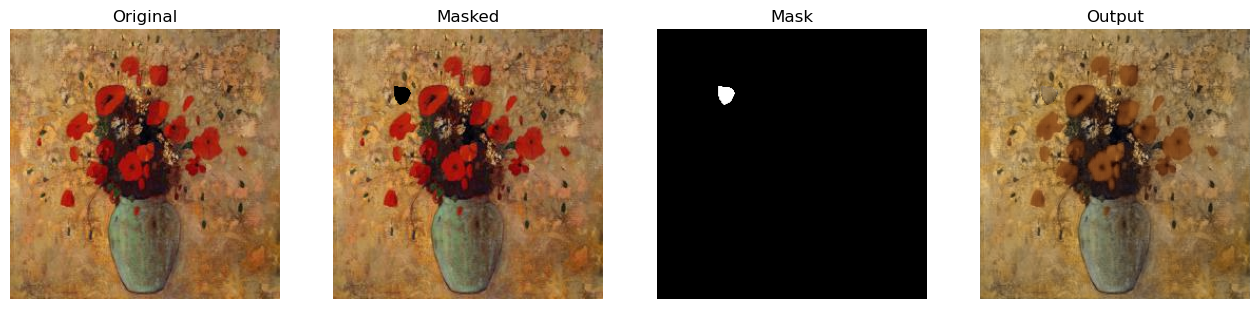

In [ ]:
checkpoint_path = r'C:\Users\Milosz\vscodeProjects\WikiArt_Inpainting\model\inpainting\best_weights_epoch_98_val_loss_37.2326-6533.pth'
test_dataset_path = r'C:\Users\Milosz\vscodeProjects\WikiArt_Inpainting\model\inpainting\test.h5'

test_dataset = WikiArtDataset(test_dataset_path, mask_type='square')

model = load_model(checkpoint_path, UNetInpainting)

evaluate_sample(test_dataset, model, device='cpu')